<a href="https://colab.research.google.com/github/emelynyrivas/Handwriting-Digit-Recognizing-Tool/blob/main/Handwriting_Digit_Recognizing_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# ---------------------------
# Mount Google Drive
# ---------------------------

from google.colab import drive
drive.mount('/content/drive')

# Define model paths in Drive
FINETUNED_MODEL_PATH = "/content/drive/MyDrive/Drive files for digit handwriting tool/mnist_digit_cnn_finetuned.h5"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# %%capture
# Install dependencies (run in Colab). If already installed, pip will skip.
#!pip install -q tensorflow==2.12.0 opencv-python-headless==4.7.0.72 matplotlib gradio==3.40.1
!pip install -q tensorflow
!pip install -q opencv-python-headless
!pip install -q matplotlib
!pip install -q gradio


In [5]:
# Imports
import os
import io
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
from PIL import Image, ImageOps

# For Gradio UI
import gradio as gr


print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [6]:
# Parameters
# ---------------------------
IMG_SIZE = 28
BATCH_SIZE = 128
EPOCHS = 20
EXPECTED_DIGITS = 5

In [7]:
# 1) Prepare MNIST dataset
# Available Dataset = MNIST
# ---------------------------

# MNIST digits are white numbers on black backgrounds.
# I will invert it to black digits on a white background.

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

# Data Preprocessing
x_train = 255.0 - x_train
x_test = 255.0 - x_test
x_train = x_train[..., np.newaxis] / 255.0
x_test = x_test[..., np.newaxis] / 255.0

print("Train / Test shapes:", x_train.shape, x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train / Test shapes: (60000, 28, 28, 1) (10000, 28, 28, 1)


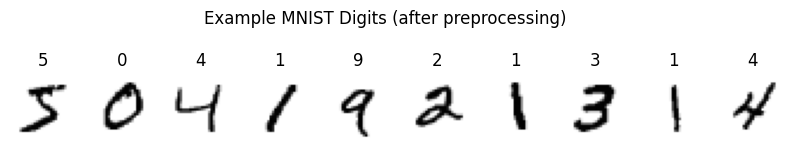

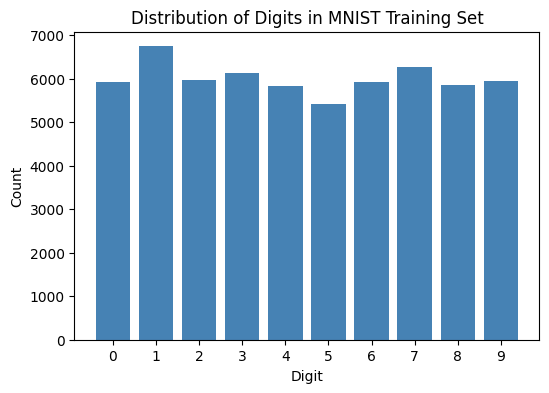

In [8]:
# Visualizations:
# Descriptive Methods - Sample MNIST Digits
#                     - Histogram of MNIST label distribution
#
# Sample MNIST Didits is a visual functionality for data exploration
# and inspection to make sure that we can visually verify that the digits and
# background are being correctly inverted.
# ---------------------------

# Sample MNIST digits
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_train[i].squeeze(), cmap="gray")
    plt.title(str(y_train[i]))
    plt.axis("off")
plt.suptitle("Example MNIST Digits (after preprocessing)")
plt.show()

# Histogram of MNIST label distribution
plt.figure(figsize=(6,4))
plt.hist(y_train, bins=np.arange(11)-0.5, rwidth=0.8, color="steelblue")
plt.xticks(range(10))
plt.xlabel("Digit")
plt.ylabel("Count")
plt.title("Distribution of Digits in MNIST Training Set")
plt.show()

In [9]:
# 2) Data augmentation
# ---------------------------
datagen = ImageDataGenerator(
    rotation_range=12,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.08,
    shear_range=0.08
)
datagen.fit(x_train)

In [10]:
# 3) Model Definition: Convolutional Neural Network
# -------------------------------------------------

def make_model(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



model = make_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,026 (1.61 MB)

 Trainable params: 421,834 (1.61 MB)

 Non-trainable params: 192 (768.00 B)

In [11]:
# 4) Train (or load if present)
# ---------------------------
from tensorflow.keras.models import load_model

FINETUNED_MODEL_PATH = "/content/drive/MyDrive/Drive files for digit handwriting tool/mnist_digit_cnn_finetuned.h5"


def get_or_train_model():

    # 1. Try fine-tuned
    if os.path.exists(FINETUNED_MODEL_PATH):
        print("Loading fine-tuned model:", FINETUNED_MODEL_PATH)
        return load_model(FINETUNED_MODEL_PATH)

    # 2. Train new model from scratch
    else:
        print("No saved model found. Training new model from scratch...")
        model = make_model()
        history = model.fit(
            datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
            validation_data=(x_test, y_test),
            epochs=EPOCHS,
            verbose=2
        )

# Load or train
model = get_or_train_model()

Loading fine-tuned model: /content/drive/MyDrive/Drive files for digit handwriting tool/mnist_digit_cnn_finetuned.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


<Figure size 800x800 with 0 Axes>

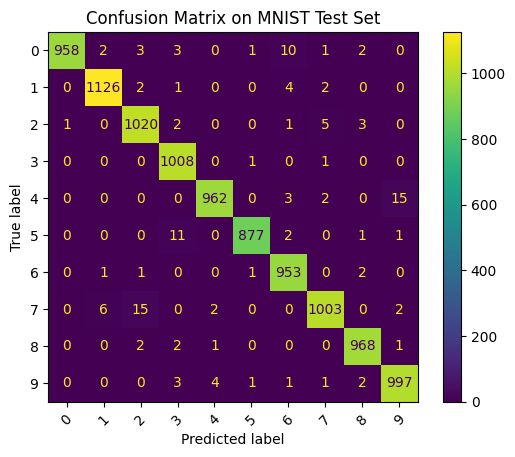

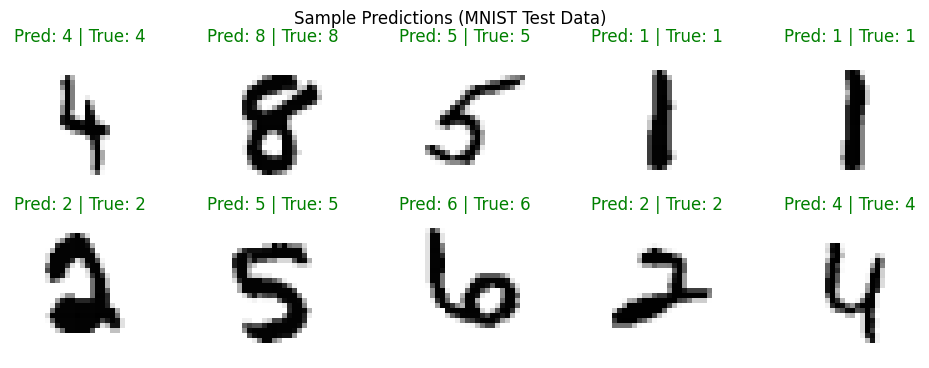

Test loss: 0.0761, Test accuracy: 0.9872


In [12]:
# 4b) Visualization:
# Non-Descriptive Methods - Confusion Matrix
#                         - Predictions
#                         - Evaluation
#
# The Confusion Matric & Sample Predictions are used to evaluate the
# accuracy of the data product and to measure training perfromance.
# ---------------------------


# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = np.argmax(model.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
plt.figure(figsize=(8,8))
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix on MNIST Test Set")
plt.show()


# Sample Predictions
plt.figure(figsize=(12,4))
for i in range(10):
    idx = np.random.randint(0, len(x_test))
    img = x_test[idx].squeeze()
    true = y_test[idx]
    pred = y_pred[idx]
    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Pred: {pred} | True: {true}",
              color="green" if pred==true else "red")
    plt.axis("off")
plt.suptitle("Sample Predictions (MNIST Test Data)")
plt.show()


# Quick evaluation
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")

In [32]:
# 5) Segmentation Functions
# These function prepare the white card photos into 28x28 samples to match the MNIST dataset.
# ---------------------------
def preprocess_card_image(pil_img: Image.Image, max_dim=1200) -> np.ndarray:
    """Return grayscale OpenCV image resized to reasonable dimensions while preserving aspect."""
    img = pil_img.convert("RGB")
    w, h = img.size
    scale = min(max_dim / float(max(w,h)), 1.0)
    new_w, new_h = int(w*scale), int(h*scale)
    img = img.resize((new_w, new_h), Image.LANCZOS)
    arr = np.array(img)
    gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    return gray

def ensure_black_on_white(gray: np.ndarray) -> np.ndarray:
    """Ensure digits are darker than background (black on white). If not, invert."""
    # Compare mean intensity of the central region vs whole image
    h, w = gray.shape
    center = gray[h//4:3*h//4, w//4:3*w//4]
    if np.mean(center) < np.mean(gray):
        # center darker than background -> likely digits white on dark background -> invert
        return 255 - gray
    return gray

def adaptive_thresh(gray: np.ndarray) -> np.ndarray:
    """Binarize image, returning binary inverted image where digits are white on black (for contour ease)."""
    # use adaptive threshold to handle lighting
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    th = cv2.adaptiveThreshold(blurred, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 15, 8)
    return th

def find_digit_contours(thresh_img: np.ndarray, min_area=50) -> List[np.ndarray]:
    """Find contours likely to be digits; filter by size and aspect ratio."""
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    h_img, w_img = thresh_img.shape
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        area = w*h
        if area < min_area:
            continue
        # filter out very tall or wide small noise
        if h < 0.2*h_img and w < 0.02*w_img:
            continue
        boxes.append((x,y,w,h))
    # sort left to right
    boxes = sorted(boxes, key=lambda b: b[0])
    return boxes

def crop_and_prepare(thresh_img, box, pad=6):
    x,y,w,h = box
    h_img, w_img = thresh_img.shape
    x0 = max(0, x-pad); y0 = max(0, y-pad)
    x1 = min(w_img, x+w+pad); y1 = min(h_img, y+h+pad)
    crop = thresh_img[y0:y1, x0:x1]

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
    crop = cv2.dilate(crop, kernel, iterations=1)

    # Resizeing to 28x28
    h_c, w_c = crop.shape
    scale = IMG_SIZE / max(h_c, w_c)
    new_w, new_h = int(w_c*scale), int(h_c*scale)
    resized = cv2.resize(crop, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Replacing the black background for a white one
    canvas = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
    x_off = (IMG_SIZE - new_w)//2
    y_off = (IMG_SIZE - new_h)//2
    canvas[y_off:y_off+new_h, x_off:x_off+new_w] = resized

    # Invert so digits are black on white (MNIST-style)
    canvas = 255 - canvas

    canvas = canvas.astype("float32") / 255.0
    canvas = canvas[..., np.newaxis]
    return canvas


def vertical_projection_split(binary_img: np.ndarray, expected=10) -> List[Tuple[int,int,int,int]]:
    """Splitting the number sequence into equal-width boxes (fallback)."""
    h, w = binary_img.shape

    coords = cv2.findNonZero(binary_img)
    if coords is None:
        return []
    x,y,wc,hc = cv2.boundingRect(coords)
    boxes = []
    w_piece = max(3, wc // expected)

    for i in range(expected):
        x0 = x + i * (wc // expected)
        x1 = x + (i+1) * (wc // expected) if i < expected-1 else x + wc
        boxes.append((x0, y, x1 - x0, hc))
    return boxes


In [33]:
# 6) Segment digits from a Card image (robust pipeline)
# ---------------------------
def segment_digits_from_pil(pil_img: Image.Image, expected_digits=EXPECTED_DIGITS, debug=False):
    """
    Returns: list of prepared 28x28 arrays ready for model and visualization boxes.
    Strategy:
      1) Preprocess, threshold (adaptive).
      2) Find contours and bounding boxes (left-to-right).
      3) If count != expected_digits, try morphological closing / dilation and re-run.
      4) For a backup solution, split the number sequence into equal-width boxes.
    """
    gray = preprocess_card_image(pil_img)
    gray = ensure_black_on_white(gray)
    th = adaptive_thresh(gray)
    boxes = find_digit_contours(th, min_area=80)


    if debug:
        print("Initial boxes:", len(boxes))
    # Fallback 1: morphological closing to join broken strokes
    if len(boxes) < expected_digits:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        th2 = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=1)
        boxes2 = find_digit_contours(th2, min_area=50)
        if debug:
            print("After closing boxes:", len(boxes2))
        if len(boxes2) >= expected_digits:
            boxes = boxes2
            th = th2

    # Fallback 2: Try dilation with wider kernel
    if len(boxes) < expected_digits:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,3))
        th3 = cv2.dilate(th, kernel, iterations=1)
        boxes3 = find_digit_contours(th3, min_area=50)
        if debug:
            print("After dilation boxes:", len(boxes3))
        if len(boxes3) >= expected_digits:
            boxes = boxes3
            th = th3

    # If we found too many boxes, try merging very small ones into neighbors
    if len(boxes) > expected_digits:
        # merge boxes that are tiny relative to median width
        widths = [w for (_,_,w,_) in boxes]
        median_w = np.median(widths) if widths else 0
        filtered = []
        i = 0
        while i < len(boxes):
            x,y,w,h = boxes[i]
            if w < 0.35 * median_w and i+1 < len(boxes):
                # merge with next
                nx,ny,nw,nh = boxes[i+1]
                merged = (x, min(y,ny), nx+nw-x, max(h, nh))
                filtered.append(merged)
                i += 2
            else:
                filtered.append(boxes[i])
                i += 1
        boxes = filtered

    # If still not enough, fallback to equal-width split across number area
    if len(boxes) != expected_digits:
        fallback_boxes = vertical_projection_split(th, expected=expected_digits)
        if debug:
            print("Fallback split produced:", len(fallback_boxes))
        if fallback_boxes:
            boxes = fallback_boxes

    # Final crop & prepare
    images = []
    viz_boxes = []  # for visualization (on resized gray)
    for b in boxes[:expected_digits]:  # limit to expected count (if too many)
        images.append(crop_and_prepare(th, b))
        viz_boxes.append(b)

    # If fewer than expected, pad with blank images
    while len(images) < expected_digits:
        blank = np.ones((IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)  # blank white -> '0' background
        images.append(blank)
        viz_boxes.append((0,0,0,0))

    return images, viz_boxes, gray, th

In [34]:
# 7) Inference: predict sequence
# ---------------------------

def predict_sequence_from_pil(pil_img: Image.Image, model, expected_digits=EXPECTED_DIGITS, debug=False):
    imgs, boxes, gray, th = segment_digits_from_pil(pil_img, expected_digits=expected_digits, debug=debug)
    X = np.stack(imgs, axis=0)
    preds = model.predict(X, verbose=0)
    digits = [str(int(np.argmax(p))) for p in preds]
    probs = [float(np.max(p)) for p in preds]
    seq = "".join(digits)
    return seq, digits, probs, boxes, gray, th


In [35]:
# 8) Utility: display segmentation + predictions
# ---------------------------

def visualize_result(pil_img: Image.Image, digits, probs, boxes, gray):
    # create a color copy of the resized gray
    color = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    for idx, (b, d, p) in enumerate(zip(boxes, digits, probs)):
        x,y,w,h = b
        if w == 0 or h == 0:
            continue
        cv2.rectangle(color, (x,y), (x+w, y+h), (0,255,0), 1)
        cv2.putText(color, f"{d} ({p*100:.0f}%)", (x, max(10,y-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
    plt.figure(figsize=(10,4))
    plt.imshow(color)
    plt.axis('off')
    plt.show()


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample1.jpg
Initial boxes: 5
Predicted sequence: 12345 | Ground truth: 12345


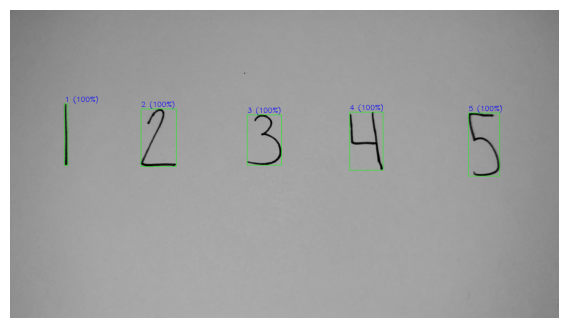


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample2.jpg
Initial boxes: 4
After closing boxes: 4
After dilation boxes: 5
Predicted sequence: 05619 | Ground truth: 05619


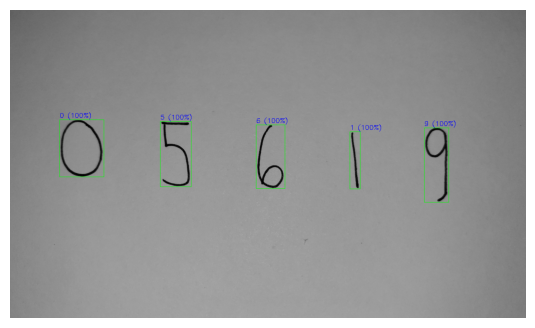


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample3.jpg
Initial boxes: 5
Predicted sequence: 00048 | Ground truth: 00048


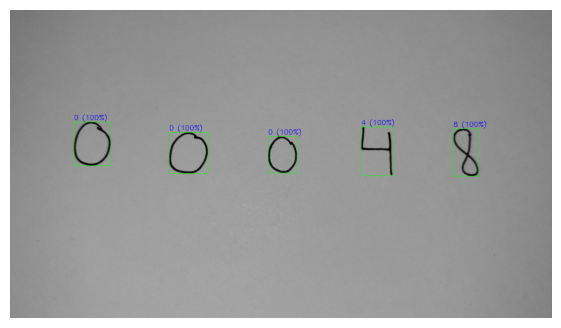


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample4.jpg
Initial boxes: 5
Predicted sequence: 17172 | Ground truth: 17172


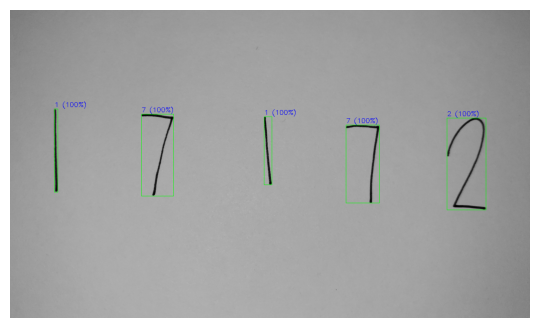


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample5.jpg
Initial boxes: 5
Predicted sequence: 44383 | Ground truth: 44383


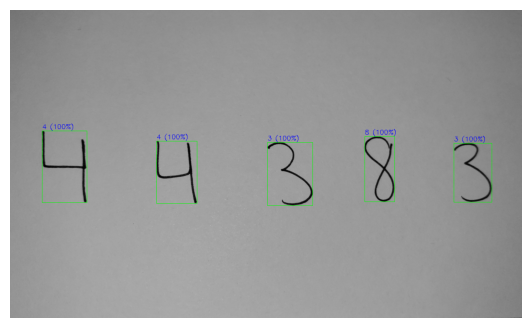


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample6.jpg
Initial boxes: 5
Predicted sequence: 27500 | Ground truth: 27500


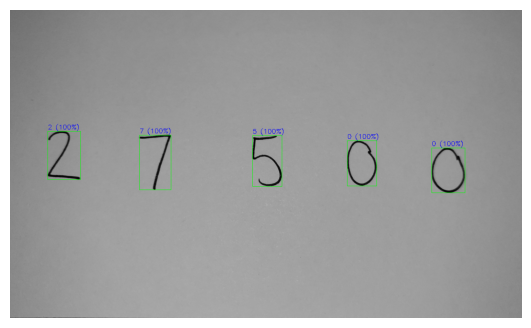


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample7.jpg
Initial boxes: 5
Predicted sequence: 27858 | Ground truth: 27858


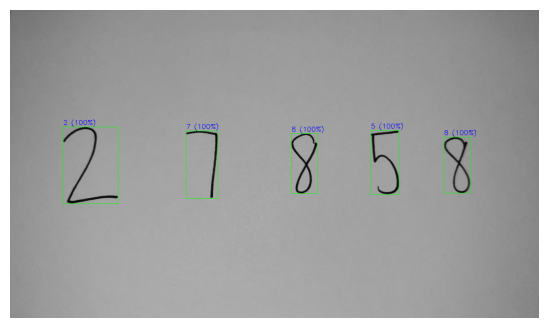


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample8.jpg
Initial boxes: 6
Predicted sequence: 90210 | Ground truth: 90210


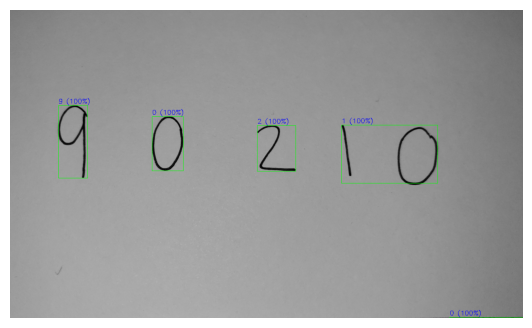


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample9.jpg
Initial boxes: 5
Predicted sequence: 96968 | Ground truth: 96968


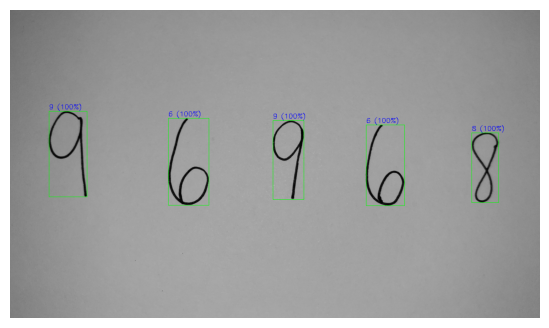


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample10.jpg
Initial boxes: 5
Predicted sequence: 78326 | Ground truth: 78326


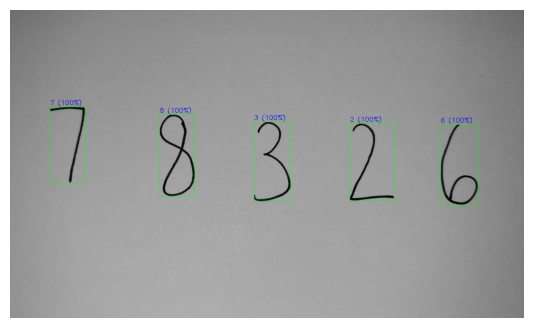


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample11.jpg
Initial boxes: 5
Predicted sequence: 77711 | Ground truth: 77711


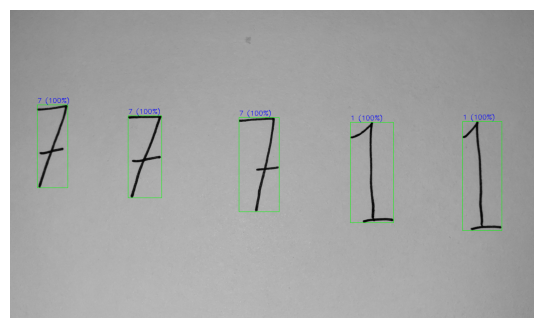


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample12.jpg
Initial boxes: 5
Predicted sequence: 71177 | Ground truth: 71177


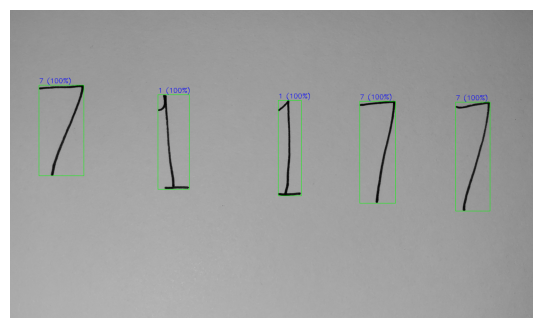


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample13.jpg
Initial boxes: 5
Predicted sequence: 71271 | Ground truth: 71271


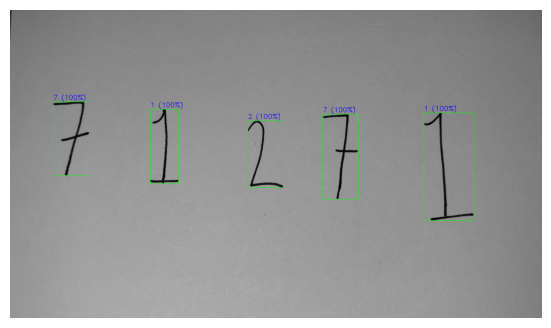


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample14.jpg
Initial boxes: 5
Predicted sequence: 71171 | Ground truth: 71171


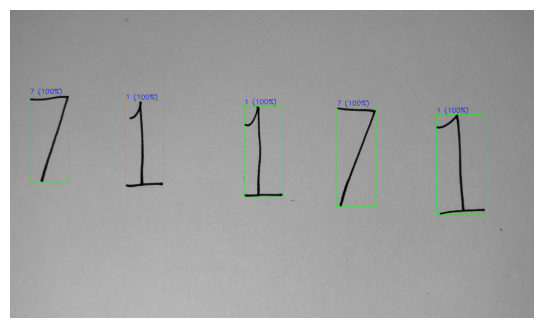


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample15.jpg
Initial boxes: 5
Predicted sequence: 20177 | Ground truth: 20177


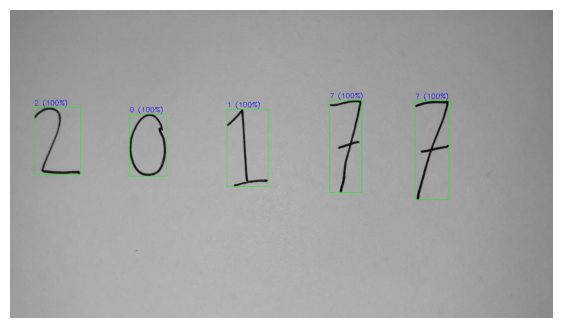


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample16.jpg
Initial boxes: 5
Predicted sequence: 01017 | Ground truth: 01017


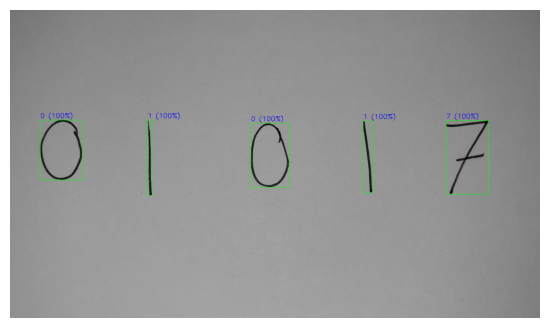


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample17.jpg
Initial boxes: 5
Predicted sequence: 17095 | Ground truth: 17095


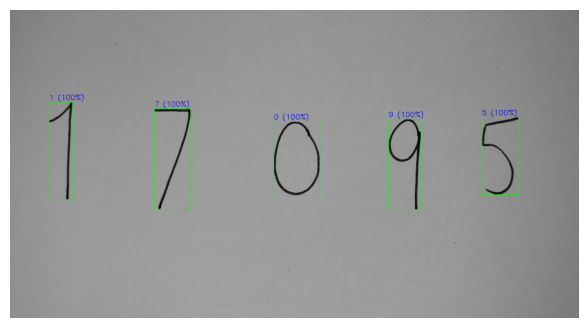


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample18.jpg
Initial boxes: 5
Predicted sequence: 69017 | Ground truth: 69017


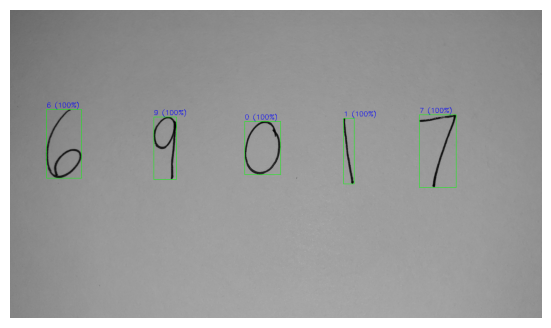


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample19.jpg
Initial boxes: 5
Predicted sequence: 12347 | Ground truth: 12347


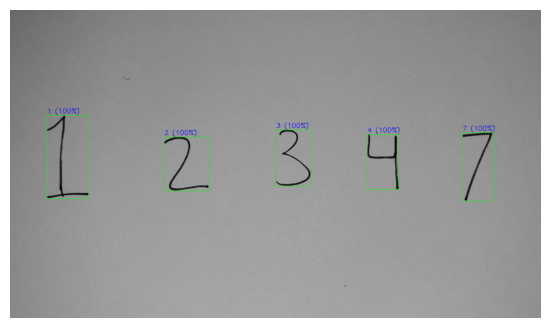


 Testing: /content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample20.jpg
Initial boxes: 5
Predicted sequence: 80717 | Ground truth: 80717


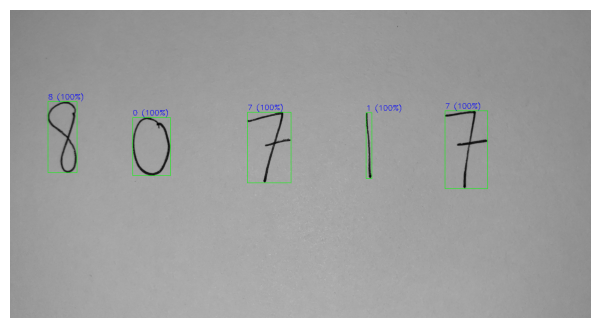

Prepared digit crops for fine-tuning: (100, 28, 28, 1) (100,)
Epoch 1/10
3/3 - 3s - 878ms/step - accuracy: 1.0000 - loss: 1.1454e-05 - val_accuracy: 1.0000 - val_loss: 7.2534e-06
Epoch 2/10
3/3 - 0s - 51ms/step - accuracy: 1.0000 - loss: 1.6838e-07 - val_accuracy: 1.0000 - val_loss: 6.0197e-06
Epoch 3/10
3/3 - 0s - 54ms/step - accuracy: 1.0000 - loss: 1.1429e-06 - val_accuracy: 1.0000 - val_loss: 4.8873e-06
Epoch 4/10
3/3 - 0s - 55ms/step - accuracy: 1.0000 - loss: 1.4901e-06 - val_accuracy: 1.0000 - val_loss: 3.4272e-06
Epoch 5/10
3/3 - 0s - 61ms/step - accuracy: 1.0000 - loss: 1.0848e-06 - val_accuracy: 1.0000 - val_loss: 2.8311e-06
Epoch 6/10
3/3 - 0s - 59ms/step - accuracy: 1.0000 - loss: 2.6822e-07 - val_accuracy: 1.0000 - val_loss: 2.4616e-06
Epoch 7/10
3/3 - 0s - 64ms/step - accuracy: 1.0000 - loss: 3.4421e-07 - val_accuracy: 1.0000 - val_loss: 2.2828e-06
Epoch 8/10
3/3 - 0s - 72ms/step - accuracy: 1.0000 - loss: 1.8477e-06 - val_accuracy: 1.0000 - val_loss: 2.0802e-06
Epoch 9/1

✅ Fine-tuned model saved to: /content/drive/MyDrive/Drive files for digit handwriting tool/mnist_digit_cnn_finetuned.h5


In [37]:
# STEP 9) Test handwritten samples with ground truth & prep for fine-tuning
# Collected Dataset = My own handwriting samples
# ---------------------------


# Maping the sample note card images with ground truth string
ground_truth = {
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample1.jpg": "12345",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample2.jpg": "05619",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample3.jpg": "00048",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample4.jpg": "17172",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample5.jpg": "44383",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample6.jpg": "27500",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample7.jpg": "27858",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample8.jpg": "90210",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample9.jpg": "96968",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample10.jpg": "78326",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample11.jpg": "77711",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample12.jpg": "71177",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample13.jpg": "71271",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample14.jpg": "71171",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample15.jpg": "20177",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample16.jpg": "01017",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample17.jpg": "17095",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample18.jpg": "69017",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample19.jpg": "12347",
    "/content/drive/MyDrive/Drive files for digit handwriting tool/handwriting_samples/5sample20.jpg": "80717",
}

digit_imgs = []
digit_labels = []

for path, true_seq in ground_truth.items():
    print("\n Testing:", path)
    pil_img = Image.open(path).convert("RGB")

    # Predict
    seq, digits, probs, boxes, gray, th = predict_sequence_from_pil(
        pil_img, model, expected_digits=len(true_seq), debug=True
    )
    print("Predicted sequence:", seq, "| Ground truth:", true_seq)

    # Visualize predictions
    visualize_result(pil_img, digits, probs, boxes, gray)

    # Collect crops + labels for fine-tuning
    imgs, _, _, _ = segment_digits_from_pil(pil_img, expected_digits=len(true_seq), debug=False)
    if len(imgs) != len(true_seq):
        print(f"⚠️ Skipping {path} — got {len(imgs)} crops but expected {len(true_seq)}")
        continue

    for i, gt_digit in enumerate(true_seq):
        digit_imgs.append(imgs[i])
        digit_labels.append(int(gt_digit))

# Convert to array
if digit_imgs:
    digit_x = np.array(digit_imgs, dtype="float32")
    digit_y = np.array(digit_labels, dtype="int64")
    print("Prepared digit crops for fine-tuning:", digit_x.shape, digit_y.shape)

    # Fine-tune the model with the handwriting sample
    from tensorflow.keras.optimizers import Adam
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    model.fit(digit_x, digit_y, epochs=10, batch_size=32,
              validation_split=0.2, verbose=2)
else:
    print(" No valid crops found for fine-tuning.")


# Saving the fine-tuned model to Google Drive

FINETUNED_MODEL_PATH = "/content/drive/MyDrive/Drive files for digit handwriting tool/mnist_digit_cnn_finetuned.h5"
model.save(FINETUNED_MODEL_PATH)
print(f"✅ Fine-tuned model saved to: {FINETUNED_MODEL_PATH}")



In [38]:
# 10) Gradio app
# A user-friendly, functional dashboard.
# ---------------------------
def gradio_predict(img: np.ndarray):
    pil = Image.fromarray(img.astype('uint8'), 'RGB')
    seq, digits, probs, boxes, gray, th = predict_sequence_from_pil(pil, model, debug=False)

    # Segmentation overlay
    color = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    for idx, (b, d, p) in enumerate(zip(boxes, digits, probs)):
        x,y,w,h = b
        if w == 0 or h == 0:
            continue
        cv2.rectangle(color, (x,y), (x+w, y+h), (0,255,0), 1)
        cv2.putText(color, f"{d} ({int(p*100)}%)", (x, max(10,y-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
    vis_pil = Image.fromarray(color)

    # Cropping the individual digits
    imgs, _, _, _ = segment_digits_from_pil(pil, expected_digits=EXPECTED_DIGITS, debug=False)
    grid_h = IMG_SIZE
    grid_w = IMG_SIZE * EXPECTED_DIGITS
    grid = Image.new("RGB", (grid_w, grid_h), "white")
    for i, arr in enumerate(imgs):
        arr_disp = (arr.squeeze() * 255).astype(np.uint8)
        arr_disp = Image.fromarray(arr_disp).convert("L").convert("RGB")
        grid.paste(arr_disp, (i*IMG_SIZE, 0))

    return seq, vis_pil, grid

# Building the Gradio interface
title = "5-digit Handwritten Digit Recognition"
description = "Upload a photo of a white note card with 5 digits written in black ink. <br> Numbers must be in 1 row. For better results, crop the photo so there is less white in the background. <br> The system will segment and predict the 5-digit sequence."

iface = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Image(type="numpy", label="Upload note card image (photo)"),
    outputs=[
        gr.Textbox(label="Predicted 5-digit sequence"),
        gr.Image(label="Segmentation overlay"),
        gr.Image(label="Individual digit crops")
    ],
    title=title,
    description=description,
    allow_flagging="never"
)

iface.launch(share=True)

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:414: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b4f530ed7aa6e1b92c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
